In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from tqdm import tqdm 
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
import os
import glob
from labellines import *
import math
from PIL import Image


divergent=LinearSegmentedColormap.from_list('divergent', (
    # Edit this gradient at https://eltos.github.io/gradient/#0D7D87-99C6CC-FBFBFB-EE9093-C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.250, (0.600, 0.776, 0.800)),
    (0.500, (0.984, 0.984, 0.984)),
    (0.750, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:0D7D87-20.8:99C6CC-40:B6B66B-60:F47A00-80:EE9093-100:C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.208, (0.600, 0.776, 0.800)),
    (0.400, (0.714, 0.714, 0.420)),
    (0.600, (0.957, 0.478, 0.000)),
    (0.800, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))
#Formatting for plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file
from src.DiscModel import DiscGalaxy
N = 1000000 # number of stars in the disc
a = 1 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

rmax = 212.
nbins = 64
mmax = 10
nmax = 10

noise = 0.5

"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""

'Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes.'

Image size: 424x424 pixels


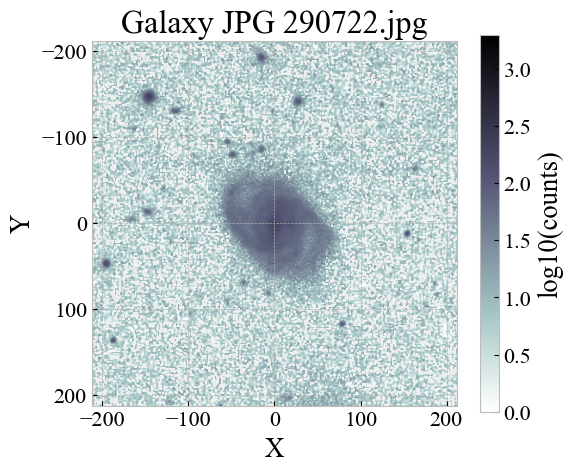

Amn (rows = n, columns = m):
[[5235.128  425.126  330.022  116.505  258.415   73.305   83.475   68.872
    72.59    32.496   10.147]
 [1520.867   53.791  554.628  156.207  195.638   83.293   69.914   42.855
    51.02    17.425   44.136]
 [ 207.079   60.693  603.79    58.173  225.818   10.      32.831  103.263
    27.9     57.519   32.506]
 [ 630.201  227.788  516.48   120.434   36.011   61.888   86.729   75.758
    37.649    6.196   18.269]
 [1194.484  174.709   84.127  169.223  136.806   83.646   51.792   78.478
   122.475   61.249   55.055]
 [ 502.741   52.61   447.359   70.528  163.364  189.382   84.072  162.687
   117.944   93.029  111.532]
 [ 357.556   77.633  291.621  149.137  642.875  124.156   62.186  101.596
   179.674  102.262   79.772]
 [  97.547  116.872   98.036  104.286   92.902   43.883   58.597   75.527
    89.109   40.335   51.792]
 [ 205.625  166.326  119.429   37.072  245.969   43.153   60.197   32.882
   124.371   84.069   80.625]
 [  17.77    39.739  222.961   49.0

Processing inclinations: 100%|██████████| 8/8 [10:24<00:00, 78.01s/inclination]

0.3278618223455878 0.0109589688104481


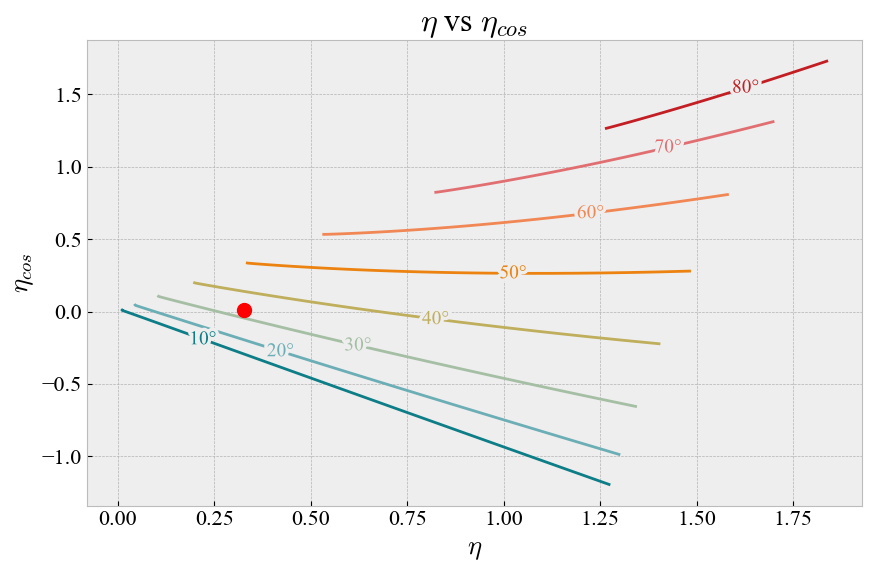

In [2]:
file="290722.jpg"  # replace with your image file
img_pil = Image.open(file).convert("L")
w, h    = img_pil.size
print(f"Image size: {w}x{h} pixels")
img_incl = np.array(img_pil, dtype=float)

x_edges = np.linspace(-rmax, rmax, w)
y_edges = np.linspace(rmax, -rmax, h)

safe     = np.where(img_incl>0, img_incl, np.nan)
log_img  = np.log10(safe)

plt.figure(figsize=(6,5))
plt.imshow(
    log_img, cmap="bone_r",
    extent=[x_edges[0],x_edges[-1],y_edges[0],y_edges[-1]],
    vmin=0, vmax=3.3
)
plt.colorbar(label="log10(counts)")
plt.title(f"Galaxy JPG {file}")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

D = DiscGalaxy(N=N, a=a)
D.img     = img_incl
D.x_edges = x_edges
D.y_edges = y_edges
D.x_centers = x_edges
D.y_centers = y_edges


E1 = D.make_expansion(mmax, nmax, 20, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)



coscoefstrue = E1.coscoefs
sincoefstrue = E1.sincoefs

Amn = np.sqrt(coscoefstrue**2 +sincoefstrue**2) 

Amn_matrix = Amn.T 

print("Amn (rows = n, columns = m):")
print(np.round(Amn_matrix,3)) 


# the grid of inclinations to draw curves for:
incl_list = np.linspace(10, 80, 8)     # eight sample inclinations
PA_list   = np.linspace(0, 80, 41)     # fine PA sampling
colorindx = np.linspace(0, 1, len(incl_list+1))  # color index for inclinations
plt.figure(figsize=(9, 6))



i=0

for inc in tqdm(incl_list, desc="Processing inclinations", unit="inclination"):
    etas      = []
    eta_cos = []
    for PA in PA_list:
        # generate the galaxy
        D = DiscGalaxy(N=N, a=a)
        D.rotate_disc(inc, PA, 0)
        D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, 20)

        c = E.coscoefs; s = E.sincoefs

        num_cos = sum(c[2,n] for n in range(nmax))
        num_sin = sum(s[2,n] for n in range(nmax))
        num     = sum(np.hypot(c[2,n], s[2,n]) for n in range(nmax))
        den     = sum(abs(c[0,n])            for n in range(nmax))

        eta     = num/den if den else np.nan
        etacos  = num_cos/den if den else np.nan
        

        etas.append(eta)
        eta_cos.append(etacos) 

    # plot one curve (inc fixed, PA varying)
    plt.plot(etas, eta_cos, '-', label=f"{inc:.0f}°", color=my_gradient(colorindx[i]))
    i += 1
    
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\eta_{cos}$")
labelLines(plt.gca().get_lines(),align=False,fontsize=14)
plt.title(r"$\eta$ vs $\eta_{cos}$")
plt.grid(True)

# now do the blind test and overplot a big marker


num_cos = sum(coscoefstrue[2,n] for n in range(nmax))

num     = sum(np.hypot(coscoefstrue[2,n], sincoefstrue[2,n]) for n in range(nmax))
den     = sum(abs(coscoefstrue[0,n])            for n in range(nmax))

eta_bt     = num/den
eta_cos_bt = num_cos/den


# big red dot
plt.plot(eta_bt, eta_cos_bt, 'o', color='red', markersize=10, label="Blind Test")
print(eta_bt, eta_cos_bt)
plt.tight_layout()
plt.show()



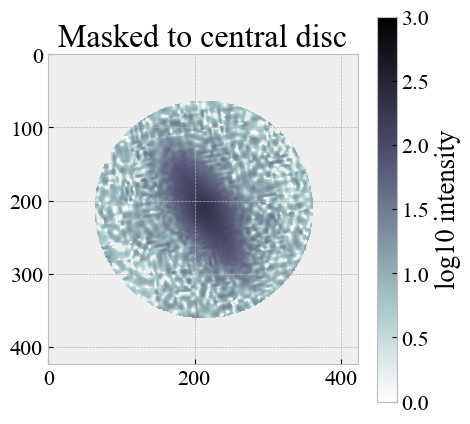

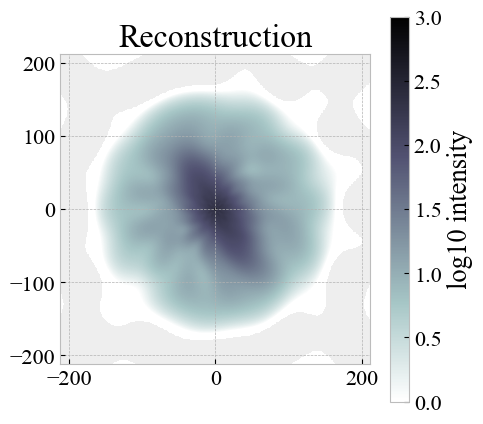

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from src.DiscModel import DiscGalaxy

#Load the image as a 2D float array
file = "99129.jpg"
gray = np.array(Image.open(file).convert("L"), dtype=float)  # shape (h, w)

h, w = gray.shape
cx, cy = w//2, h//2
radius = 150  # in pixels

# Build the circular mask
y, x = np.indices((h,w))
mask = (x - cx)**2 + (y - cy)**2 <= radius**2

# Apply it: keep the disc, zero (or nan) outside
disc_only = np.where(mask, gray, 0.0)

#Quick check that only the central disc remains
plt.figure(figsize=(5,5))
plt.imshow(np.log10(np.where(disc_only>0, disc_only, np.nan)),
            cmap='bone_r',
           vmin=0, vmax=3)
plt.colorbar(label='log10 intensity')
plt.title("Masked to central disc")
plt.show()

#feed into original DiscGalaxy pipeline
  # physical half‐width of the image
# set up your grid exactly as before:
x_edges = np.linspace(-rmax, rmax, w+1)
y_edges = np.linspace(-rmax, rmax, h+1)
x_centers = 0.5*(x_edges[:-1] + x_edges[1:])
y_centers = 0.5*(y_edges[:-1] + y_edges[1:])

D = DiscGalaxy(N=N,a=a)       # no N needed
D.img       = disc_only.T   # transpose → shape = (nx, ny)
D.x_edges   = x_edges
D.y_edges   = y_edges
D.x_centers = x_centers
D.y_centers = y_centers

# Expand & reconstruct just as you wrote originally
mmax, nmax = 14, 10
E1 = D.make_expansion(mmax, nmax, 15, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)

# Histogram back & plot
X2, Y2   = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat   = X2.ravel();     y_flat   = Y2.ravel()
w_flat   = E1.reconstruction.ravel()

recon_img, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges],
    weights=w_flat
)
counts, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges]
)
recon_img = recon_img / np.maximum(counts, 1)
recon_img *= np.sum(disc_only) / np.sum(recon_img)
recon_img = recon_img.T

plt.figure(figsize=(5,5))
plt.imshow(np.log10(np.where(recon_img>0, recon_img, np.nan)), cmap='bone_r',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=0, vmax=3)
plt.colorbar(label='log10 intensity')
plt.title("Reconstruction")
plt.show()




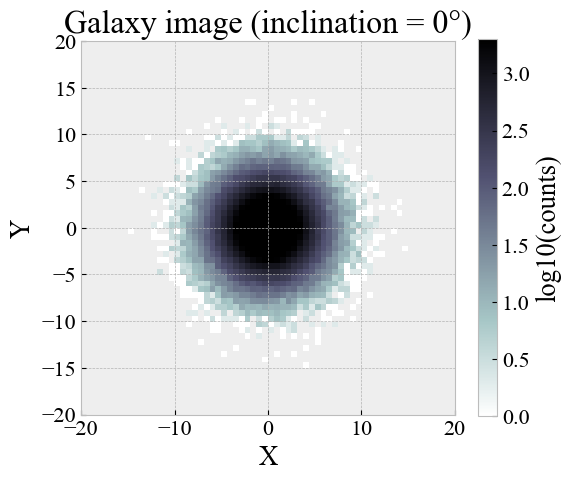

Amn inc= 0 (rows = n, columns = m):
[[0.153 0.001 0.    0.    0.    0.    0.001]
 [0.043 0.    0.    0.    0.    0.    0.   ]
 [0.01  0.001 0.    0.    0.    0.    0.   ]
 [0.002 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


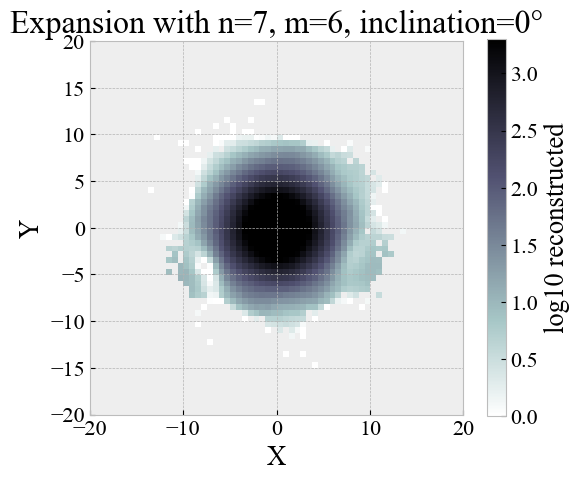

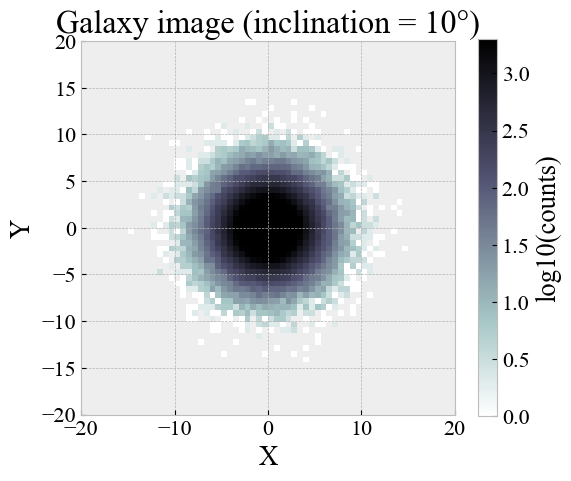

Amn inc= 10 (rows = n, columns = m):
[[0.154 0.001 0.001 0.    0.    0.    0.001]
 [0.044 0.    0.    0.    0.    0.    0.   ]
 [0.011 0.001 0.    0.    0.    0.    0.   ]
 [0.002 0.001 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


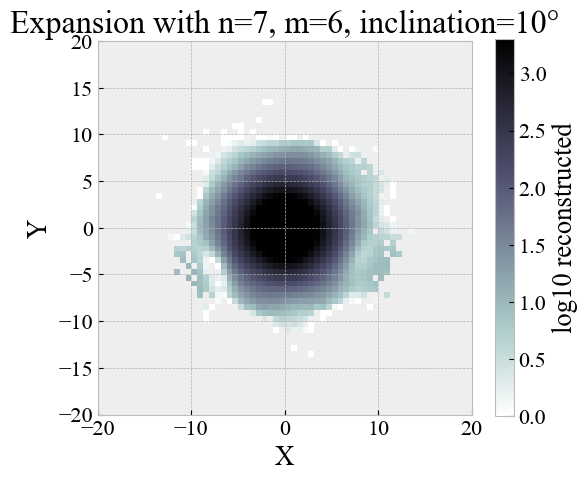

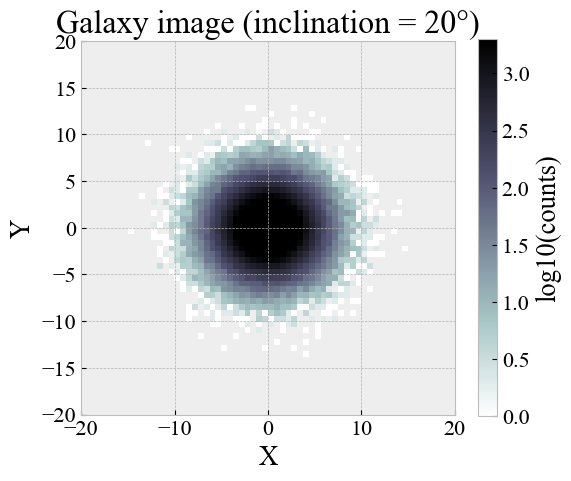

Amn inc= 20 (rows = n, columns = m):
[[0.156 0.001 0.006 0.    0.    0.    0.001]
 [0.047 0.    0.002 0.    0.    0.    0.   ]
 [0.012 0.001 0.001 0.    0.    0.    0.   ]
 [0.003 0.001 0.001 0.    0.    0.    0.   ]
 [0.001 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


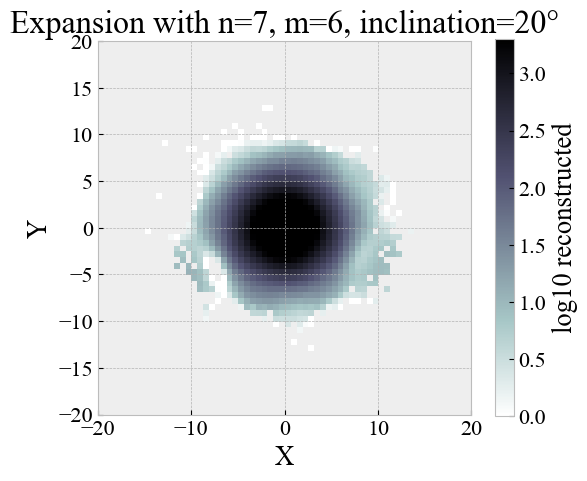

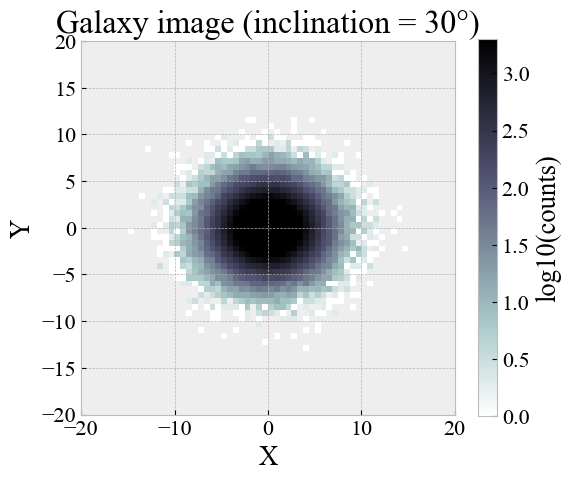

Amn inc= 30 (rows = n, columns = m):
[[0.161 0.001 0.014 0.    0.001 0.    0.001]
 [0.053 0.    0.003 0.    0.001 0.    0.   ]
 [0.015 0.001 0.003 0.    0.    0.    0.   ]
 [0.004 0.001 0.001 0.    0.    0.    0.   ]
 [0.001 0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


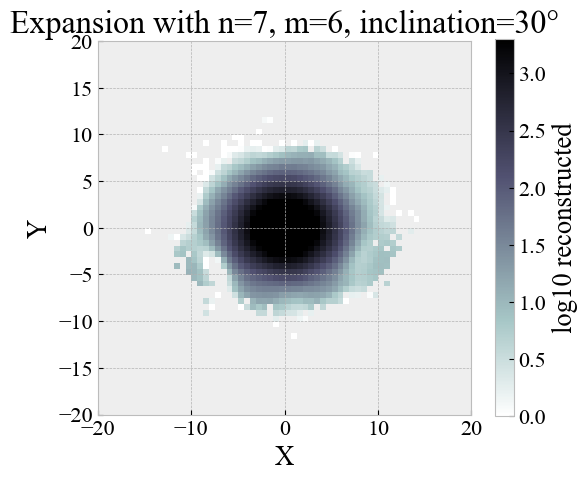

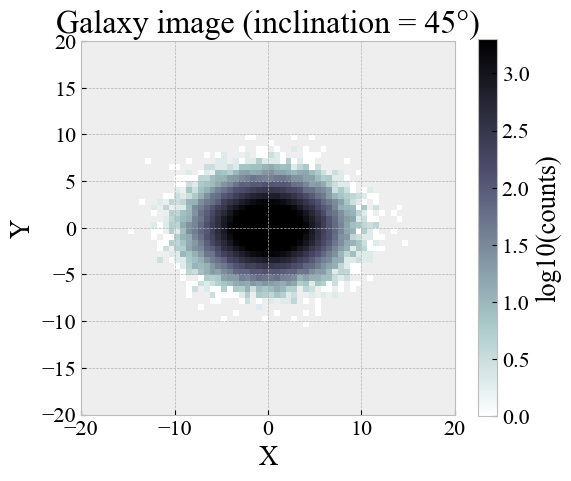

Amn inc= 45 (rows = n, columns = m):
[[0.172 0.001 0.038 0.    0.005 0.    0.001]
 [0.068 0.001 0.004 0.    0.002 0.    0.   ]
 [0.024 0.001 0.008 0.    0.001 0.    0.   ]
 [0.008 0.001 0.005 0.    0.    0.    0.   ]
 [0.003 0.001 0.002 0.    0.    0.    0.   ]
 [0.001 0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.    0.   ]]


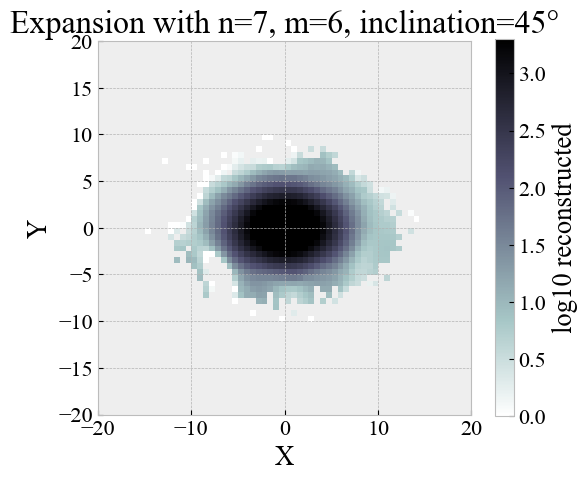

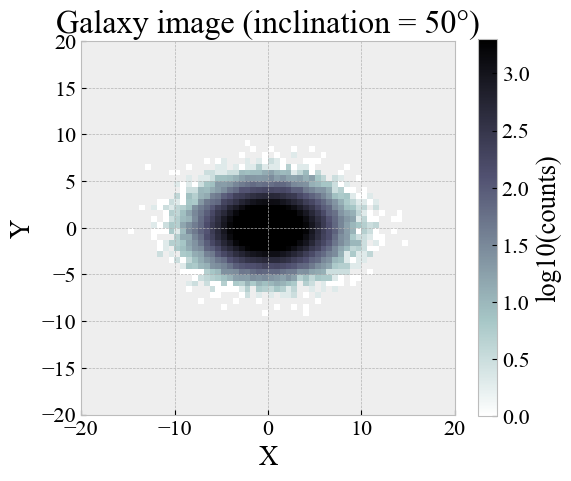

Amn inc= 50 (rows = n, columns = m):
[[0.177 0.001 0.05  0.    0.008 0.    0.002]
 [0.075 0.001 0.003 0.    0.003 0.    0.001]
 [0.029 0.001 0.01  0.    0.002 0.    0.   ]
 [0.011 0.001 0.007 0.    0.001 0.    0.   ]
 [0.004 0.001 0.003 0.    0.    0.    0.   ]
 [0.001 0.    0.002 0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.    0.   ]]


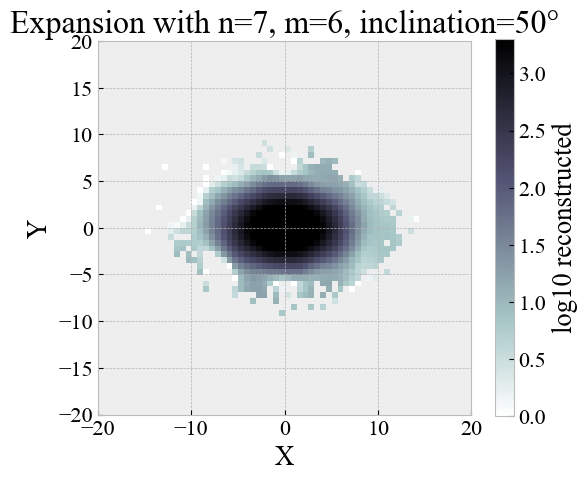

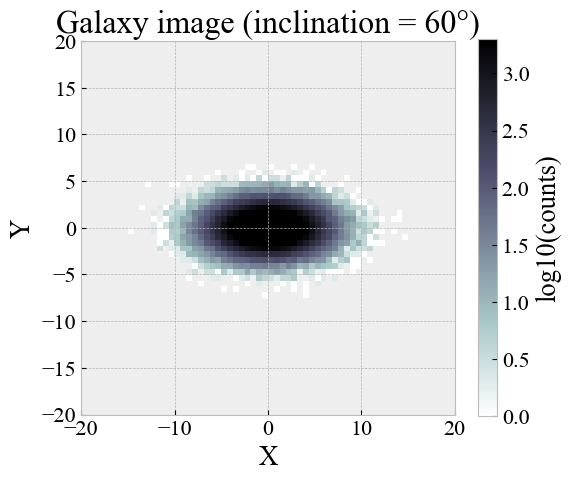

Amn inc= 60 (rows = n, columns = m):
[[0.188 0.001 0.086 0.    0.022 0.001 0.006]
 [0.092 0.001 0.004 0.    0.006 0.    0.003]
 [0.042 0.001 0.014 0.    0.006 0.    0.001]
 [0.02  0.001 0.012 0.    0.003 0.    0.   ]
 [0.009 0.001 0.008 0.    0.001 0.    0.   ]
 [0.004 0.001 0.005 0.    0.    0.    0.   ]
 [0.002 0.    0.003 0.    0.    0.    0.   ]]


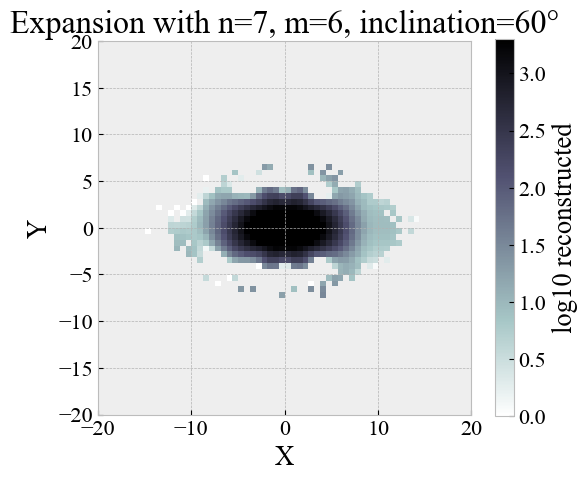

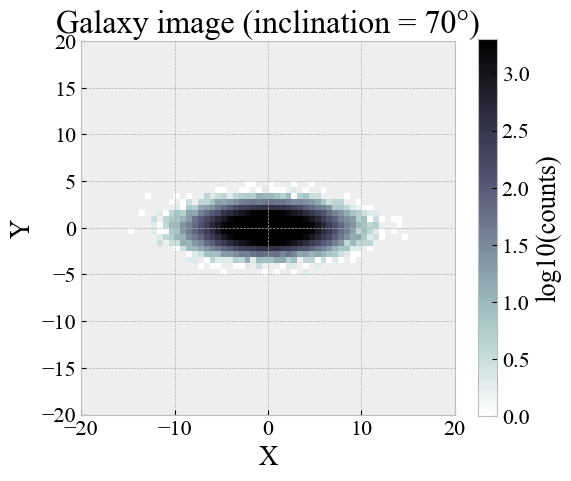

Amn inc= 70 (rows = n, columns = m):
[[0.202 0.001 0.146 0.    0.057 0.001 0.023]
 [0.115 0.001 0.029 0.    0.004 0.    0.006]
 [0.064 0.001 0.01  0.    0.013 0.    0.007]
 [0.037 0.001 0.017 0.001 0.01  0.    0.003]
 [0.022 0.001 0.016 0.    0.005 0.    0.001]
 [0.013 0.001 0.012 0.    0.003 0.    0.   ]
 [0.008 0.001 0.008 0.    0.001 0.    0.   ]]


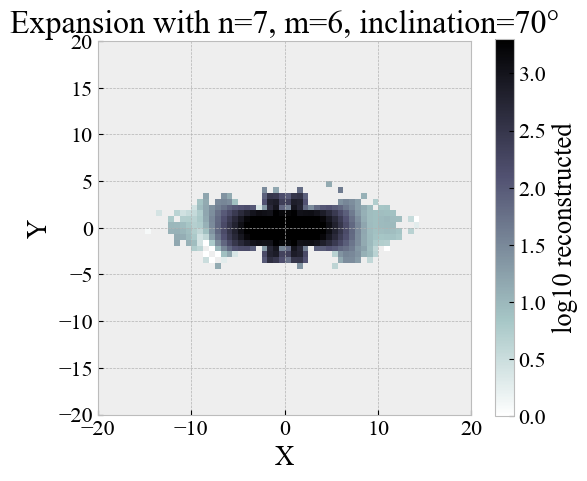

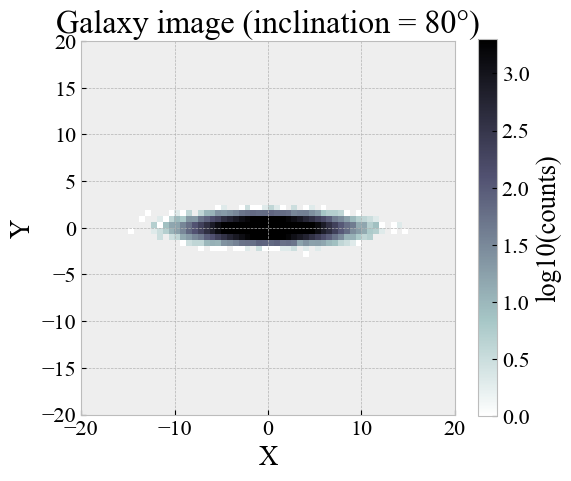

Amn inc= 80 (rows = n, columns = m):
[[0.215 0.001 0.25  0.001 0.151 0.    0.094]
 [0.142 0.001 0.102 0.    0.034 0.    0.007]
 [0.096 0.001 0.032 0.    0.008 0.001 0.016]
 [0.069 0.001 0.001 0.001 0.019 0.001 0.017]
 [0.051 0.001 0.011 0.001 0.018 0.    0.012]
 [0.039 0.001 0.016 0.001 0.015 0.    0.008]
 [0.03  0.001 0.017 0.    0.011 0.    0.004]]


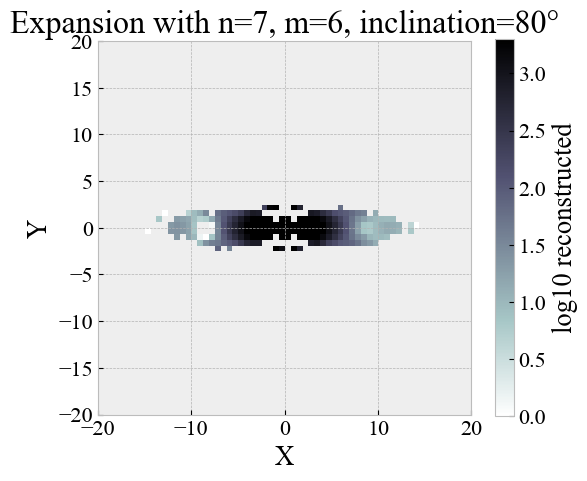

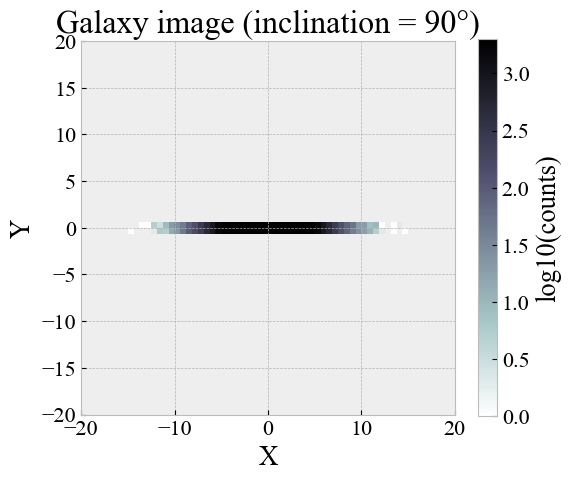

Amn inc= 90 (rows = n, columns = m):
[[0.224 0.    0.449 0.    0.449 0.    0.449]
 [0.163 0.    0.325 0.    0.325 0.    0.325]
 [0.126 0.    0.252 0.    0.252 0.    0.252]
 [0.106 0.001 0.211 0.001 0.211 0.001 0.211]
 [0.093 0.001 0.186 0.001 0.186 0.001 0.186]
 [0.084 0.001 0.168 0.001 0.168 0.001 0.168]
 [0.077 0.    0.155 0.    0.155 0.    0.155]]


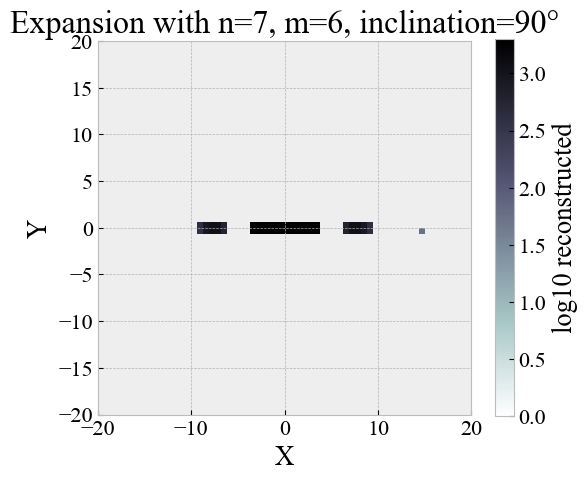

In [4]:
rmax=20

inc = [0,10,20,30,45,50,60,70,80,90] # degrees, change as needed

for inc in inc:
    """Generating the galaxy image with the specified inclination"""
    D = DiscGalaxy(N=N, a=a)  # adjust N and a as needed
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    img_orig = D.img.copy()

    # Replace zero pixels with NaN to avoid log10(-inf) warnings

    safe_img = np.where(D.img > 0, D.img, np.nan)
    log_img = np.log10(safe_img)


    """Plotting the galaxy image"""

    plt.figure(figsize=(6, 5))
    plt.imshow(log_img, origin='lower', cmap='bone_r',
            extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
            vmin=0., vmax=3.3)
    plt.colorbar(label='log10(counts)')
    plt.title(f"Galaxy image (inclination = {inc}°)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()


    m,n=6,7 #Toggle this to see the expansion coefficients and how they change, goal: find the closest match to the image

    E1 = D.make_pointexpansion(m,n,a*1.5,noisy=False) # Expanding the image 
    c = E1.coscoefs; s = E1.sincoefs
    Amn = np.sqrt(E1.coscoefs**2 +E1.sincoefs**2) 
    Amn_matrix = Amn.T 
    print(f"Amn inc= {inc} (rows = n, columns = m):")
    print(np.round(Amn_matrix,3)) 
    
    """Reconstruct an image from the expansion coefficients"""

    E1.laguerre_reconstruction(D.r,D.p)

    x , y= D.r * np.cos(D.p), D.r * np.sin(D.p) # Convert polar coordinates to Cartesian coordinates

    bins = [D.x_edges, D.y_edges]

    recon_img, _, _ = np.histogram2d(x, y, bins=bins, weights=E1.reconstruction)
    counts, _, _ = np.histogram2d(x, y, bins=bins)
    recon_img /= np.maximum(counts, 1)
    recon_img *= np.sum(img_orig) / np.sum(recon_img)
    recon_img = recon_img.T

    safe_recon = np.where(recon_img > 0, recon_img, np.nan)
    log_recon = np.log10(safe_recon)

    """Plotting the reconstructed image"""

    plt.figure(figsize=(6, 5))
    plt.imshow(log_recon, origin='lower', cmap='bone_r',
            extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
            vmin=0., vmax=3.3)
    plt.colorbar(label='log10 reconstructed')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Expansion with n={n}, m={m}, inclination={inc}°')
    plt.tight_layout()
    plt.show()

  


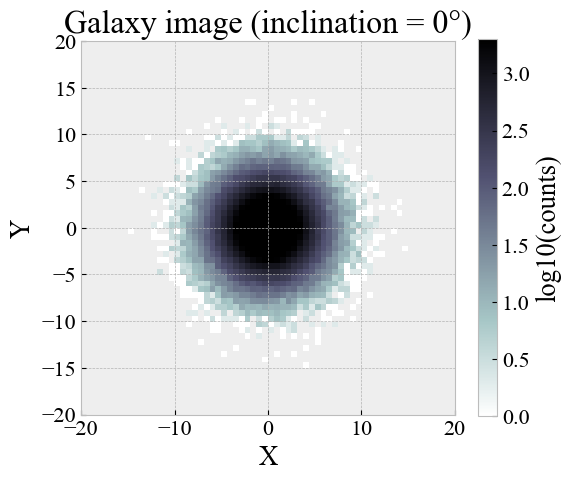

Amn inc= 0 (rows = n, columns = m):
[[0.153 0.001 0.    0.    0.    0.    0.001]
 [0.043 0.    0.    0.    0.    0.    0.   ]
 [0.01  0.001 0.    0.    0.    0.    0.   ]
 [0.002 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


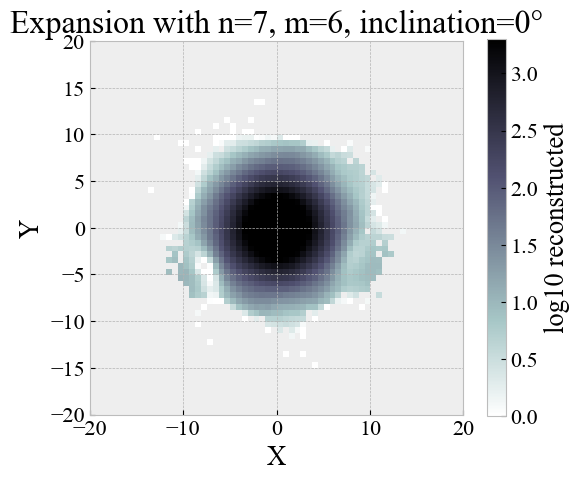

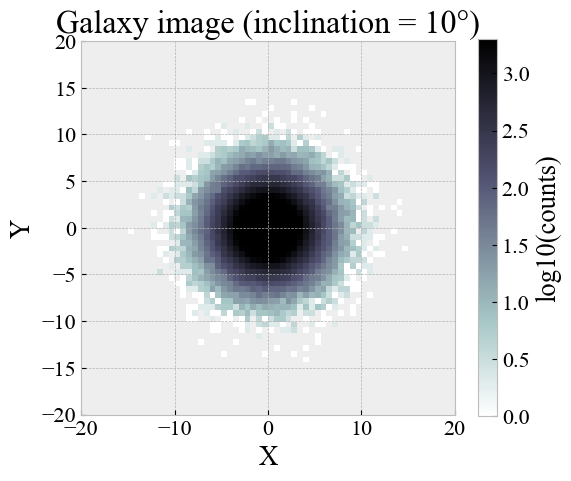

Amn inc= 10 (rows = n, columns = m):
[[0.154 0.001 0.001 0.    0.    0.    0.001]
 [0.044 0.    0.    0.    0.    0.    0.   ]
 [0.011 0.001 0.    0.    0.    0.    0.   ]
 [0.002 0.001 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


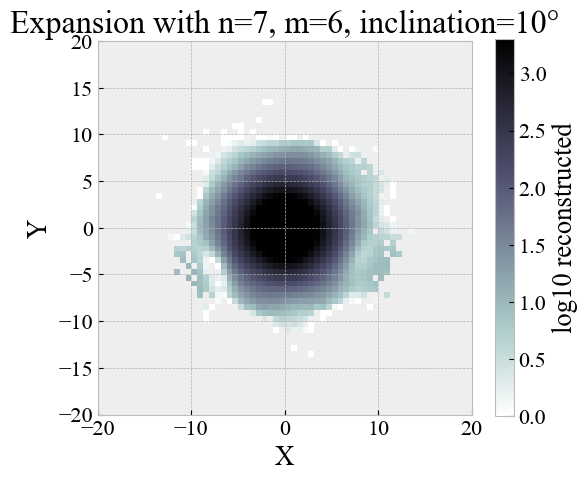

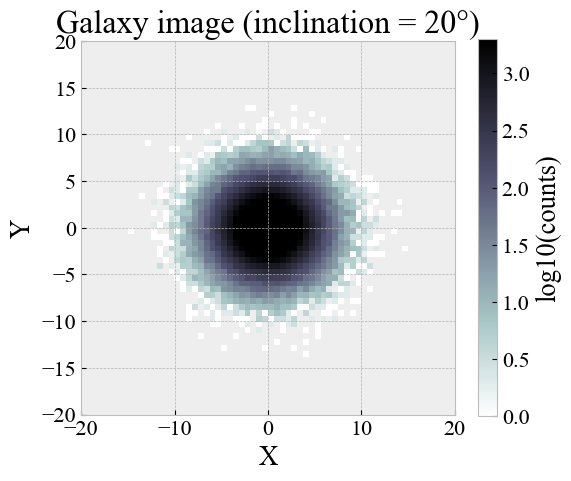

Amn inc= 20 (rows = n, columns = m):
[[0.156 0.001 0.006 0.    0.    0.    0.001]
 [0.047 0.    0.002 0.    0.    0.    0.   ]
 [0.012 0.001 0.001 0.    0.    0.    0.   ]
 [0.003 0.001 0.001 0.    0.    0.    0.   ]
 [0.001 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


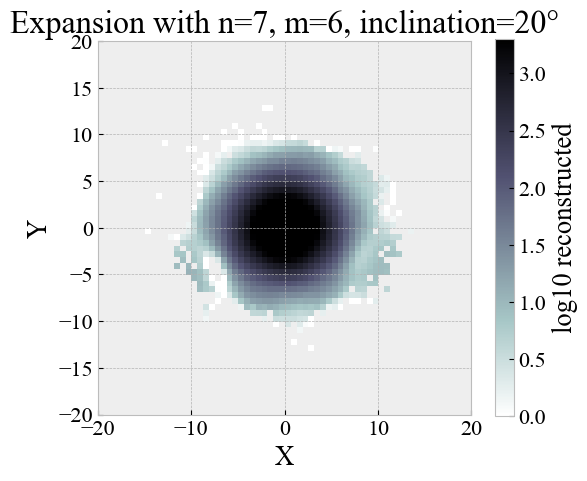

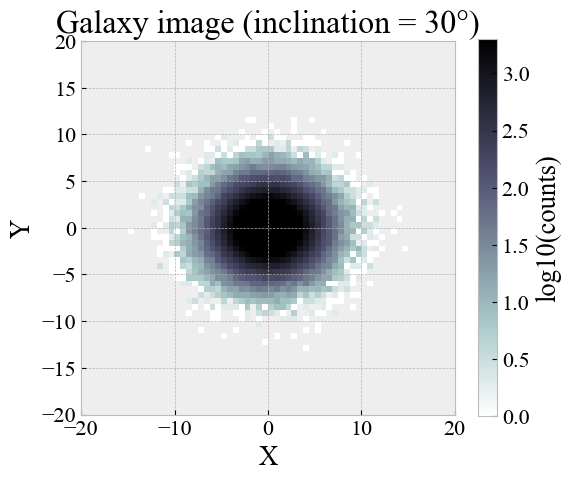

Amn inc= 30 (rows = n, columns = m):
[[0.161 0.001 0.014 0.    0.001 0.    0.001]
 [0.053 0.    0.003 0.    0.001 0.    0.   ]
 [0.015 0.001 0.003 0.    0.    0.    0.   ]
 [0.004 0.001 0.001 0.    0.    0.    0.   ]
 [0.001 0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


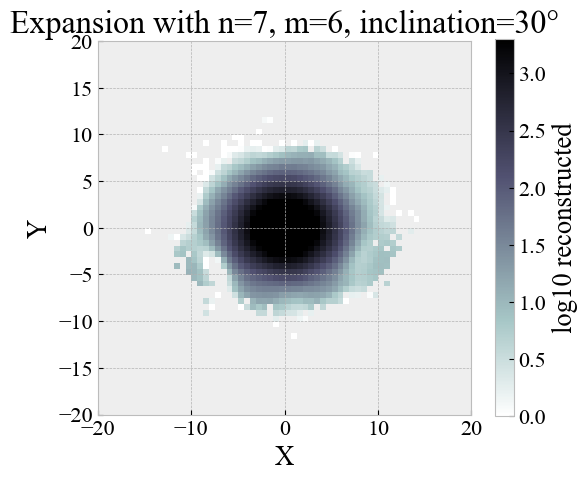

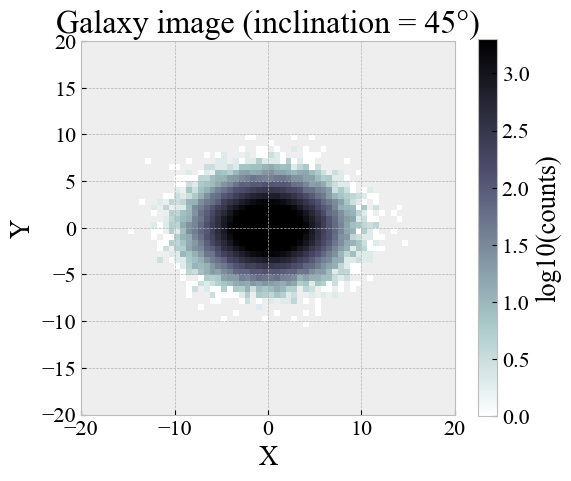

Amn inc= 45 (rows = n, columns = m):
[[0.172 0.001 0.038 0.    0.005 0.    0.001]
 [0.068 0.001 0.004 0.    0.002 0.    0.   ]
 [0.024 0.001 0.008 0.    0.001 0.    0.   ]
 [0.008 0.001 0.005 0.    0.    0.    0.   ]
 [0.003 0.001 0.002 0.    0.    0.    0.   ]
 [0.001 0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.    0.   ]]


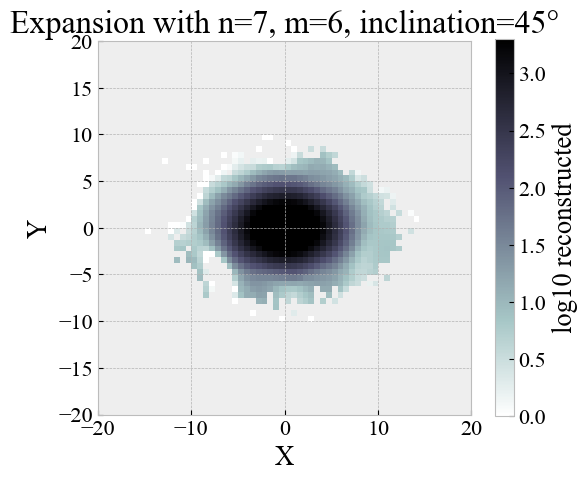

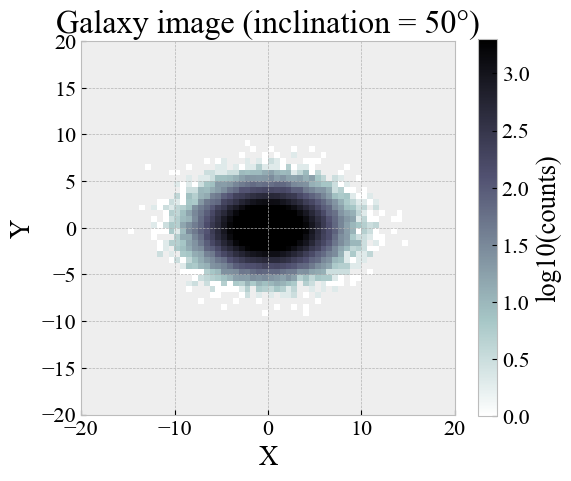

Amn inc= 50 (rows = n, columns = m):
[[0.177 0.001 0.05  0.    0.008 0.    0.002]
 [0.075 0.001 0.003 0.    0.003 0.    0.001]
 [0.029 0.001 0.01  0.    0.002 0.    0.   ]
 [0.011 0.001 0.007 0.    0.001 0.    0.   ]
 [0.004 0.001 0.003 0.    0.    0.    0.   ]
 [0.001 0.    0.002 0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.    0.   ]]


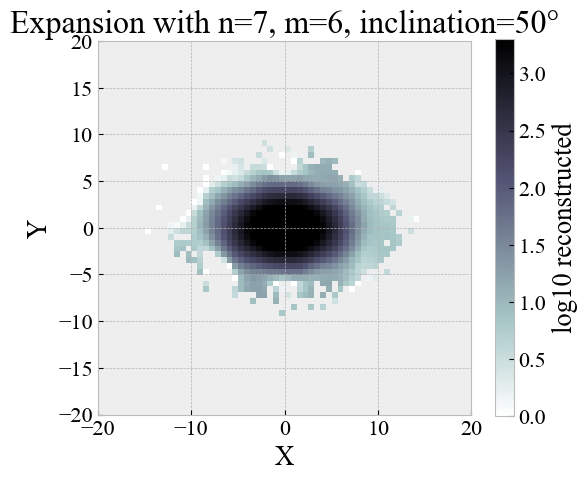

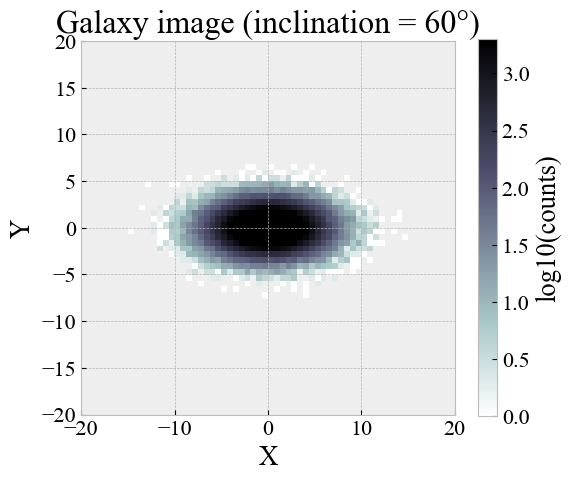

Amn inc= 60 (rows = n, columns = m):
[[0.188 0.001 0.086 0.    0.022 0.001 0.006]
 [0.092 0.001 0.004 0.    0.006 0.    0.003]
 [0.042 0.001 0.014 0.    0.006 0.    0.001]
 [0.02  0.001 0.012 0.    0.003 0.    0.   ]
 [0.009 0.001 0.008 0.    0.001 0.    0.   ]
 [0.004 0.001 0.005 0.    0.    0.    0.   ]
 [0.002 0.    0.003 0.    0.    0.    0.   ]]


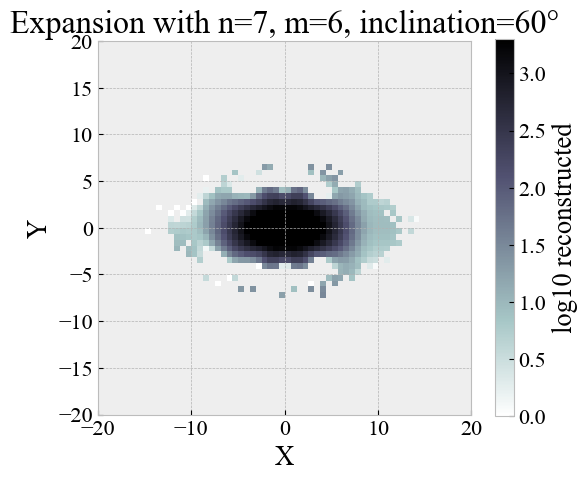

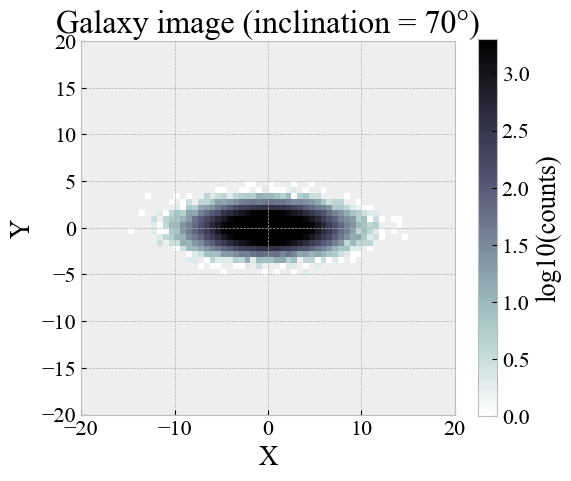

Amn inc= 70 (rows = n, columns = m):
[[0.202 0.001 0.146 0.    0.057 0.001 0.023]
 [0.115 0.001 0.029 0.    0.004 0.    0.006]
 [0.064 0.001 0.01  0.    0.013 0.    0.007]
 [0.037 0.001 0.017 0.001 0.01  0.    0.003]
 [0.022 0.001 0.016 0.    0.005 0.    0.001]
 [0.013 0.001 0.012 0.    0.003 0.    0.   ]
 [0.008 0.001 0.008 0.    0.001 0.    0.   ]]


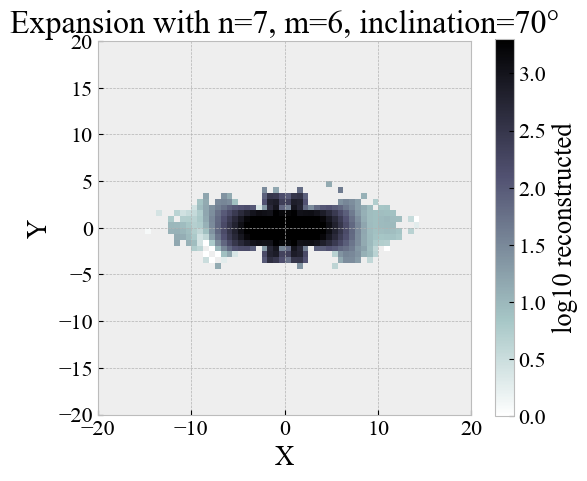

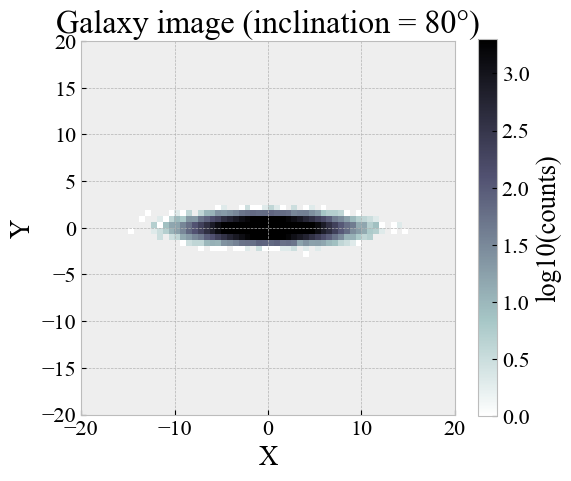

Amn inc= 80 (rows = n, columns = m):
[[0.215 0.001 0.25  0.001 0.151 0.    0.094]
 [0.142 0.001 0.102 0.    0.034 0.    0.007]
 [0.096 0.001 0.032 0.    0.008 0.001 0.016]
 [0.069 0.001 0.001 0.001 0.019 0.001 0.017]
 [0.051 0.001 0.011 0.001 0.018 0.    0.012]
 [0.039 0.001 0.016 0.001 0.015 0.    0.008]
 [0.03  0.001 0.017 0.    0.011 0.    0.004]]


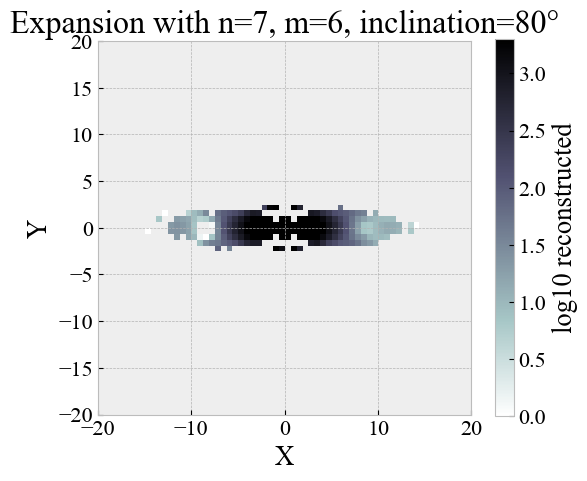

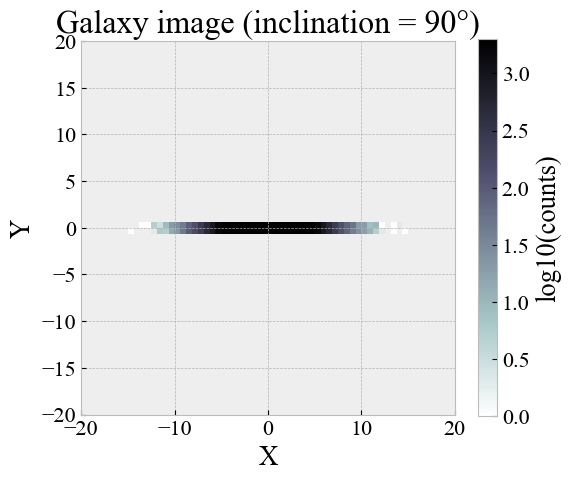

Amn inc= 90 (rows = n, columns = m):
[[0.224 0.    0.449 0.    0.449 0.    0.449]
 [0.163 0.    0.325 0.    0.325 0.    0.325]
 [0.126 0.    0.252 0.    0.252 0.    0.252]
 [0.106 0.001 0.211 0.001 0.211 0.001 0.211]
 [0.093 0.001 0.186 0.001 0.186 0.001 0.186]
 [0.084 0.001 0.168 0.001 0.168 0.001 0.168]
 [0.077 0.    0.155 0.    0.155 0.    0.155]]


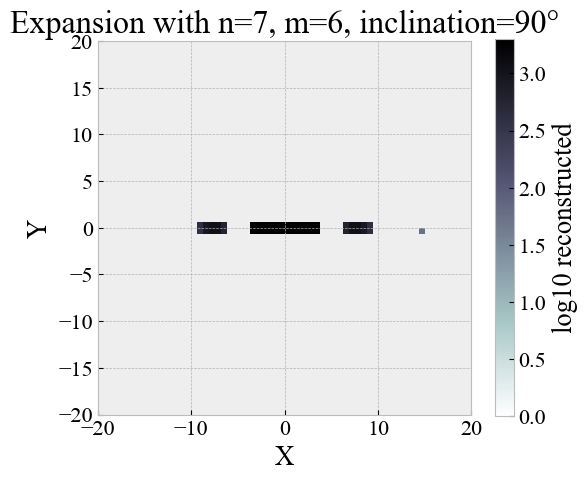

In [ ]:
rmax=20

inc = [0,10,20,30,45,50,60,70,80,90] # degrees, change as needed

for inc in inc:
    """Generating the galaxy image with the specified inclination"""
    D = DiscGalaxy(N=N, a=a)  # adjust N and a as needed
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    img_orig = D.img.copy()

    # Replace zero pixels with NaN to avoid log10(-inf) warnings

    safe_img = np.where(D.img > 0, D.img, np.nan)
    log_img = np.log10(safe_img)


    """Plotting the galaxy image"""

    plt.figure(figsize=(6, 5))
    plt.imshow(log_img, origin='lower', cmap='bone_r',
            extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
            vmin=0., vmax=3.3)
    plt.colorbar(label='log10(counts)')
    plt.title(f"Galaxy image (inclination = {inc}°)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()


    m,n=6,7 #Toggle this to see the expansion coefficients and how they change, goal: find the closest match to the image

    E1 = D.make_pointexpansion(m,n,a*1.5,noisy=False) # Expanding the image 
    c = E1.coscoefs; s = E1.sincoefs
    Amn = np.sqrt(E1.coscoefs**2 +E1.sincoefs**2) 
    Amn_matrix = Amn.T 
    print(f"Amn inc= {inc} (rows = n, columns = m):")
    print(np.round(Amn_matrix,3)) 
    """Reconstruct an image from the expansion coefficients"""

    E1.laguerre_reconstruction(D.r,D.p)

    x , y= D.r * np.cos(D.p), D.r * np.sin(D.p) # Convert polar coordinates to Cartesian coordinates

    bins = [D.x_edges, D.y_edges]

    recon_img, _, _ = np.histogram2d(x, y, bins=bins, weights=E1.reconstruction)
    counts, _, _ = np.histogram2d(x, y, bins=bins)
    recon_img /= np.maximum(counts, 1)
    recon_img *= np.sum(img_orig) / np.sum(recon_img)
    recon_img = recon_img.T

    safe_recon = np.where(recon_img > 0, recon_img, np.nan)
    log_recon = np.log10(safe_recon)

    """Plotting the reconstructed image"""

    plt.figure(figsize=(6, 5))
    plt.imshow(log_recon, origin='lower', cmap='bone_r',
            extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
            vmin=0., vmax=3.3)
    plt.colorbar(label='log10 reconstructed')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Expansion with n={n}, m={m}, inclination={inc}°')
    plt.tight_layout()
    plt.show()

  


In [ ]:

inc_list = [0,10,20,30,45,50,60,70,80,90]
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

for inc in inc_list:
    # — Generate the galaxy & log image —
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    img_orig = D.img.copy()
    safe_img = np.where(D.img > 0, D.img, np.nan)
    log_img  = np.log10(safe_img)

    # — Save the original log-image —
    fig = plt.figure(figsize=(6,5))
    plt.imshow(log_img, origin='lower', cmap='bone_r',
               extent=[D.x_edges[0], D.x_edges[-1],
                       D.y_edges[0], D.y_edges[-1]],
               vmin=0., vmax=3.3)
    plt.colorbar(label='log10(counts)')
    plt.title(f"Galaxy (inc={inc}°)")
    plt.xlabel("X"); plt.ylabel("Y")
    plt.tight_layout()
    fn1 = os.path.join(output_dir, f"galaxy_inc{inc:02d}_orig.png")
    plt.savefig(fn1, dpi=300)
    plt.close(fig)

    # — Compute & save the Amn matrix —
    m, n = 6, 7
    E1 = D.make_pointexpansion(m, n, a*1.5, noisy=False)
    Amn_matrix = np.sqrt(E1.coscoefs**2 + E1.sincoefs**2).T
    # save as text (tab- or comma-delimited)
    fn_npy = os.path.join(output_dir, f"Amn_inc{inc:02d}.npy")
    np.save(fn_npy, Amn_matrix)
    print(f"Saved Amn matrix for inc={inc}° to {fn_npy}")

    print(f"Saved Amn matrix for inc={inc}° to {fn_npy}")

    # — Reconstruct & save the reconstructed log-image —
    E1.laguerre_reconstruction(D.r, D.p)
    x, y = D.r*np.cos(D.p), D.r*np.sin(D.p)
    bins = [D.x_edges, D.y_edges]
    recon_img, _, _ = np.histogram2d(x, y, bins=bins, weights=E1.reconstruction)
    counts,    _, _ = np.histogram2d(x, y, bins=bins)
    recon_img /= np.maximum(counts, 1)
    recon_img *= np.sum(img_orig) / np.sum(recon_img)
    recon_img = recon_img.T
    safe_recon = np.where(recon_img > 0, recon_img, np.nan)
    log_recon  = np.log10(safe_recon)

    fig = plt.figure(figsize=(6,5))
    plt.imshow(log_recon, origin='lower', cmap='bone_r',
               extent=[D.x_edges[0], D.x_edges[-1],
                       D.y_edges[0], D.y_edges[-1]],
               vmin=0., vmax=3.3)
    plt.colorbar(label='log10 reconstructed')
    plt.title(f"Reconstruction (inc={inc}°)")
    plt.xlabel("X"); plt.ylabel("Y")
    plt.tight_layout()
    fn3 = os.path.join(output_dir, f"galaxy_inc{inc:02d}_recon.png")
    plt.savefig(fn3, dpi=300)
    plt.close(fig)


Saved Amn matrix for inc=0° to outputs/Amn_inc00.npy
Saved Amn matrix for inc=0° to outputs/Amn_inc00.npy
Saved Amn matrix for inc=10° to outputs/Amn_inc10.npy
Saved Amn matrix for inc=10° to outputs/Amn_inc10.npy
Saved Amn matrix for inc=20° to outputs/Amn_inc20.npy
Saved Amn matrix for inc=20° to outputs/Amn_inc20.npy
Saved Amn matrix for inc=30° to outputs/Amn_inc30.npy
Saved Amn matrix for inc=30° to outputs/Amn_inc30.npy
Saved Amn matrix for inc=45° to outputs/Amn_inc45.npy
Saved Amn matrix for inc=45° to outputs/Amn_inc45.npy
Saved Amn matrix for inc=50° to outputs/Amn_inc50.npy
Saved Amn matrix for inc=50° to outputs/Amn_inc50.npy
Saved Amn matrix for inc=60° to outputs/Amn_inc60.npy
Saved Amn matrix for inc=60° to outputs/Amn_inc60.npy
Saved Amn matrix for inc=70° to outputs/Amn_inc70.npy
Saved Amn matrix for inc=70° to outputs/Amn_inc70.npy
Saved Amn matrix for inc=80° to outputs/Amn_inc80.npy
Saved Amn matrix for inc=80° to outputs/Amn_inc80.npy
Saved Amn matrix for inc=90° t